# Block 9 Workshop 09.3: Tensorflow and Keras 

```
date: "Block 09"
author: "Daniel Lawson"
email: dan.lawson@bristol.ac.uk
output: html_document
version: 1.0.1
```

This is a very simple example of a working neural network approach for cyber security data.

## Tensorflow/Keras setup

We first need to install tensorflow and keras:

In [1]:
!pip3 install tensorflow keras

## Practical reference

The setup procedure is borrowed from:

https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

## Data

TOR cyber data:

http://www.unb.ca/cic/research/datasets/tor.html

18Mb csv and 22Gb pcap data.

https://www.unb.ca/cic/datasets/tor.html

https://www.analyticsvidhya.com/blog/2018/07/using-power-deep-learning-cyber-security/

We'll start with a very fast example and then examine problems specific to cyber data.

In [2]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Start with the Pima Indians onset of diabetes dataset. This is a standard machine learning dataset from the UCI Machine Learning repository. It describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years.

As such, it is a binary classification problem (onset of diabetes as 1 or not as 0). All of the input variables that describe each patient are numerical. This makes it easy to use directly with neural networks that expect numerical input and output values, and ideal for our first neural network in Keras.

* [Diabetes data](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv)
* [Diabetes column names](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)

Download the dataset and place it in an appropriate data directory, and update the path below to reflect this.


In [3]:
import requests
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv?raw=true'
r = requests.get(url, allow_redirects=True)
open('../data/pima-indians-diabetes.data.csv', 'wb').write(r.content)

23278

In [4]:
# load pima indians dataset
dataset = np.loadtxt("../data/pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

In [5]:
dataset.shape

(768, 9)

In [6]:
X[0,:]

array([  6.   , 148.   ,  72.   ,  35.   ,   0.   ,  33.6  ,   0.627,
        50.   ])

## Cyber data

Cyber data can be downloaded from 

TorCSV.zip

This is the CSV data from https://www.unb.ca/cic/datasets/tor.html. 

This is the citation:

Arash Habibi Lashkari, Gerard Draper-Gil, Mohammad Saiful Islam Mamun and Ali A. Ghorbani, "Characterization of Tor Traffic Using Time Based Features", In the proceeding of the 3rd International Conference on Information System Security and Privacy, SCITEPRESS, Porto, Portugal, 2017.

We have extracted only a single file here, and password encrypted it. To access the rest of the documents, you need to agree to the T&Cs and download the files directly from UNB. (Which is free for academic use.)

In [7]:
import requests

## Get the arff data
url = 'https://github.com/dsbristol/dst/blob/master/data/SelectedFeatures-15s-TOR-NonTOR.arff.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('../data/SelectedFeatures-15s-TOR-NonTOR.arff.zip', 'wb').write(r.content)

## Get the csv data
url = 'https://github.com/dsbristol/dst/blob/master/data/merged_5s.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('../data/merged_5s.zip', 'wb').write(r.content)

4391912

Programatically extract the data:

In [8]:
from zipfile import ZipFile

with ZipFile('../data/SelectedFeatures-15s-TOR-NonTOR.arff.zip') as zf:
    zf.extractall(pwd=b'dsbristol',path="../data/")
with ZipFile('../data/merged_5s.zip') as zf:
    zf.extractall(pwd=b'dsbristol',path="../data/")

If you are having trouble navigating your file system, the following can help:

In [9]:
import os 
os.getcwd()

'/Users/madjl/code/dst-private/Workshops'

## Defining a model

Models in Keras are defined as a sequence of layers.

We create a Sequential model and add layers one at a time until we are happy with our network topology.

The first thing to get right is to ensure the input layer has the right number of inputs. This can be specified when creating the first layer with the input_dim argument and setting it to 8 for the 8 input variables.

How do we know the number of layers and their types?

This is a very hard question. There are heuristics that we can use and often the best network structure is found through a process of trial and error experimentation. Generally, you need a network large enough to capture the structure of the problem.

In this example, we will use a fully-connected network structure with three layers.

Fully connected layers are defined using the Dense class. We can specify the number of neurons in the layer as the first argument, the initialization method as the second argument as init and specify the activation function using the activation argument.

In this case, we initialize the network weights to a small random number generated from a uniform distribution (‘uniform‘), in this case between 0 and 0.05 because that is the default uniform weight initialization in Keras. Another traditional alternative would be ‘normal’ for small random numbers generated from a Gaussian distribution.

We will use the rectifier (‘relu‘) activation function on the first two layers and the sigmoid function in the output layer. It used to be the case that sigmoid and tanh activation functions were preferred for all layers. These days, better performance is achieved using the rectifier activation function. We use a sigmoid on the output layer to ensure our network output is between 0 and 1 and easy to map to either a probability of class 1 or snap to a hard classification of either class with a default threshold of 0.5.

We can piece it all together by adding each layer. The first layer has 12 neurons and expects 8 input variables. The second hidden layer has 8 neurons and finally, the output layer has 1 neuron to predict the class (onset of diabetes or not).

In [10]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## Compiling the model

Now that the model is defined, we can compile it.

Compiling the model uses the efficient numerical libraries under the covers (the so-called backend) such as Theano or TensorFlow. The backend automatically chooses the best way to represent the network for training and making predictions to run on your hardware, such as CPU or GPU or even distributed.

When compiling, we must specify some additional properties required when training the network. Remember training a network means finding the best set of weights to make predictions for this problem.

We must specify the loss function to use to evaluate a set of weights, the optimizer used to search through different weights for the network and any optional metrics we would like to collect and report during training.

In this case, we will use logarithmic loss, which for a binary classification problem is defined in Keras as “binary_crossentropy“. We will also use the efficient gradient descent algorithm “adam” for no other reason that it is an efficient default. Learn more about the Adam optimization algorithm in the paper “Adam: A Method for Stochastic Optimization“.

Finally, because it is a classification problem, we will collect and report the classification accuracy as the metric.

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model fitting

We have defined our model and compiled it ready for efficient computation.

Now it is time to execute the model on some data.

We can train or fit our model on our loaded data by calling the fit() function on the model.

The training process will run for a fixed number of iterations through the dataset called epochs, that we must specify using the nepochs argument. We can also set the number of instances that are evaluated before a weight update in the network is performed, called the batch size and set using the batch_size argument.

For this problem, we will run for a small number of iterations (150) and use a relatively small batch size of 10. Again, these can be chosen experimentally by trial and error.

In [12]:
model.fit(X, Y, epochs=150, batch_size=10)

Epoch 1/150
77/77 [==============================] - 1s 1ms/step - loss: 4.2758 - accuracy: 0.5326
Epoch 2/150
77/77 [==============================] - 0s 2ms/step - loss: 2.4582 - accuracy: 0.5191
Epoch 3/150
77/77 [==============================] - 0s 2ms/step - loss: 1.6956 - accuracy: 0.5584
Epoch 4/150
77/77 [==============================] - 0s 2ms/step - loss: 0.9625 - accuracy: 0.6352
Epoch 5/150
77/77 [==============================] - 0s 2ms/step - loss: 0.9682 - accuracy: 0.6157
Epoch 6/150
77/77 [==============================] - 0s 1ms/step - loss: 0.8911 - accuracy: 0.6400
Epoch 7/150
77/77 [==============================] - 0s 2ms/step - loss: 0.9675 - accuracy: 0.6205
Epoch 8/150
77/77 [==============================] - 0s 2ms/step - loss: 0.9411 - accuracy: 0.6079
Epoch 9/150
77/77 [==============================] - 0s 2ms/step - loss: 0.7595 - accuracy: 0.6575
Epoch 10/150
77/77 [==============================] - 0s 2ms/step - loss: 0.7689 - accuracy: 0.6513
Epoch 11/

77/77 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.7594
Epoch 84/150
77/77 [==============================] - 0s 1ms/step - loss: 0.4945 - accuracy: 0.7644
Epoch 85/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5662 - accuracy: 0.7192
Epoch 86/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5350 - accuracy: 0.7411
Epoch 87/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5050 - accuracy: 0.7600
Epoch 88/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5460 - accuracy: 0.7207
Epoch 89/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5690 - accuracy: 0.7191
Epoch 90/150
77/77 [==============================] - 0s 1ms/step - loss: 0.5118 - accuracy: 0.7801
Epoch 91/150
77/77 [==============================] - 0s 2ms/step - loss: 0.5360 - accuracy: 0.7534
Epoch 92/150
77/77 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7666
Epoch 93/150


## Model evaluation

This is the **training** accuracy.

In [13]:
# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

24/24 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7669

accuracy: 76.69%


Now we'll extract the predictions and compare the direction of error.

In [14]:
predictions = model.predict(X)
rounded = [round(x[0]) for x in predictions]

In [15]:
import pandas as pd
pd.crosstab(rounded-Y,columns="Residual")

col_0,Residual
row_0,
-1.0,128
0.0,589
1.0,51


### Application to cyber data

In [16]:
## How to load the arff files
from scipy.io import arff
data, meta = arff.loadarff("../data/SelectedFeatures-15s-TOR-NonTOR.arff")
## NB We don't actually use the arff files in this example, 
## though you may choose to in the assessment.

In [17]:
meta # This is the information about the data we just read

Dataset: <ISCXFlowMeter-generated-flows>,,,,
	min_fiat's type is numeric
	min_biat's type is numeric
	max_fiat's type is numeric
	max_biat's type is numeric
	class1's type is nominal, range is ('TOR', 'NONTOR')

### Cyber security data processing
On to the CSV file. We'll do the standard examination of the data.

In [18]:
import pandas as pd
df=pd.read_csv('../data/merged_5s.csv', sep=',')

In [19]:
df.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,...,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
0,10.0.2.15,53913,216.58.208.46,80,6,435,0.0,4597.701149,435.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
1,10.0.2.15,53913,216.58.208.46,80,6,259,0.0,7722.007722,259.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
2,10.0.2.15,53913,216.58.208.46,80,6,891,0.0,2244.668911,891.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
3,10.0.2.15,53913,216.58.208.46,80,6,1074,0.0,1862.197393,1074.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR
4,10.0.2.15,53913,216.58.208.46,80,6,315,0.0,6349.206349,315.0,0.0,...,0,0,0,0,0,0,0,0,0,nonTOR


In [20]:
df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,...,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,84194.000000,84194.000000,84194.000000,8.419400e+04,8.419200e+04,8.419400e+04,8.419400e+04,8.419400e+04,8.419400e+04,8.419400e+04,...,8.419400e+04,8.419400e+04,8.419400e+04,84194.0,8.419400e+04,8.419400e+04,8.419400e+04,84194.0,8.419400e+04,8.419400e+04
mean,36548.661686,13160.683802,11.709041,1.976443e+06,inf,inf,2.345857e+05,1.060288e+05,5.085555e+05,1.692679e+05,...,2.699017e+05,3.730249e+04,1.879716e+04,0.0,1.879716e+04,1.879716e+04,1.585213e+05,0.0,1.585213e+05,1.585213e+05
std,21514.574423,19549.475949,5.496059,2.143432e+06,NaN,NaN,5.300413e+05,2.847677e+05,8.607729e+05,5.012712e+05,...,6.769662e+05,2.460999e+05,1.437066e+05,0.0,1.437066e+05,1.437066e+05,7.603776e+05,0.0,7.603776e+05,7.603776e+05
min,21.000000,21.000000,6.000000,0.000000e+00,0.000000e+00,4.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.255000e+03,...,0.000000e+00,-3.270000e+02,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
25%,15685.000000,137.000000,6.000000,1.110615e+05,1.068141e+02,4.874711e+00,9.873663e+03,0.000000e+00,3.537575e+04,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
50%,42381.000000,443.000000,17.000000,4.207625e+05,1.952058e+03,2.966216e+01,4.652450e+04,3.953863e+03,1.556870e+05,4.930000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
75%,54420.000000,19302.000000,17.000000,4.838636e+06,2.596406e+04,1.040035e+02,3.334988e+05,4.637779e+04,4.427632e+05,1.358822e+05,...,1.216798e+05,4.400000e+01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
max,65534.000000,65514.000000,17.000000,5.000000e+06,inf,inf,5.000000e+06,3.535258e+06,5.000000e+06,5.000000e+06,...,4.998709e+06,4.998709e+06,2.447136e+06,0.0,2.447136e+06,2.447136e+06,5.000000e+06,0.0,5.000000e+06,5.000000e+06


In [21]:
df.shape

(84194, 29)

In [22]:
pd.crosstab(df.label,columns='label')

col_0,label
label,
TOR,14508
nonTOR,69686


In [23]:
np.random.seed(7)
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True)
kfsplit=kf.split(df)
## We're going to extract out the "test" dataset from the first fold, to do our testing on
# kf.split returns an iterator, i.e. it creates a function that creates a test/split
# which we can either loop over or get the first using next
ninefolds,onefold=next(kfsplit) 
mydata=df.loc[ninefolds]
mytestdata=df.loc[onefold]

In [24]:
mydata.values[:,0:28]

array([['10.0.2.15', 53913, '216.58.208.46', ..., 0, 0, 0],
       ['10.0.2.15', 53913, '216.58.208.46', ..., 0, 0, 0],
       ['10.0.2.15', 53913, '216.58.208.46', ..., 0, 0, 0],
       ...,
       ['131.202.240.87', 11365, '31.13.73.1', ..., 0, 0, 0],
       ['10.0.2.15', 51024, '37.97.149.8', ..., 0, 0, 0],
       ['131.202.6.26', 13000, '131.202.240.87', ..., 0, 0, 0]],
      dtype=object)

### First try: Run the neural network on the data

In [25]:
## This function is useful for establishing which elements in an array are true
## It is a port of the R function of the same name
def which(self):
    try:
        self = list(iter(self))
    except TypeError as e:
        raise Exception("""'which' method can only be applied to iterables.
        {}""".format(str(e)))
    indices = [i for i, x in enumerate(self) if bool(x) == True]
    return(indices)

In [26]:
## Extract out the columns for which we'll do learning
torcols=which(mydata.apply(pd.Series.nunique) != 1) 
# list(range(0,mydata.shape[1]-1)) # We need to remove: IP addresses, and constant columns
torcols.pop(2) # Remove Dest IP 
torcols.pop(0) # Remove Source IP
torcols.pop()  # Remove Tor/NonTor label

traindata = mydata[mydata.columns[torcols]].copy()
testdata  = mytestdata[mytestdata.columns[torcols]].copy()

In [27]:
## Extract the labels:
def myextractY(data):
    ## Extract the Tor/nonTor data as 0/1 values
    TorYfactor=pd.factorize(data)
    TorY=TorYfactor[0] # Keep ToyYfactor around to know which is which
    return(TorY,TorYfactor[1])

TorY,TorYnames=myextractY(mydata.values[:,mydata.shape[1]-1])
testTorY,testTorYnames=myextractY(mytestdata.values[:,mytestdata.shape[1]-1])

In [28]:
## Examine the Y values
pd.crosstab(TorY,columns='label')

col_0,label
row_0,
0,62747
1,13027


### An example of failure

Neural network code will enthusiastically proceed even if there is something wrong.

Here, we procude the data to the model "as is" without any sanitisation.

It will not work, but it will run....

In [29]:
TorX=traindata.values
testTorX=testdata.values

In [30]:
## Define a model
tormodel = Sequential()
tormodel.add(Dense(24, input_dim=TorX.shape[1], activation='relu'))
tormodel.add(Dense(TorX.shape[1], activation='relu'))
tormodel.add(Dense(1, activation='sigmoid'))
tormodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
tormodel.fit(TorX, TorY, epochs=1, batch_size=100)

758/758 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.8216


In [32]:
torscores = tormodel.evaluate(TorX, TorY)
print("\n%s: %.2f%%" % (tormodel.metrics_names[1], torscores[1]*100))

2368/2368 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.8281

accuracy: 82.81%


In [32]:
testtorscores = tormodel.evaluate(testTorX, testTorY)
print("\n%s: %.2f%%" % (tormodel.metrics_names[1], testtorscores[1]*100))

264/264 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.8241

accuracy: 82.41%


We get `nan` loss functions. This is a problem!
### Try 2: standardizing the input data

We'll first examine what the data is doing.

You have to be careful because several functions replace NA and infinite values stealthily...

In [33]:
pd.crosstab(mydata.values[:,0],columns="Flow Bytes/s").describe()

col_0,Flow Bytes/s
count,723.000000
mean,104.804979
std,680.466092
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,9410.000000


Whereas others reveal these issues

In [34]:
traindata.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,...,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min
count,75774.000000,75774.000000,75774.000000,7.577400e+04,7.577300e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,...,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04
mean,36532.521907,13177.342532,11.712236,1.978014e+06,inf,inf,2.351684e+05,1.064205e+05,5.094632e+05,1.695085e+05,...,8.379887e+04,6.905067e+04,2.699219e+05,3.764953e+04,1.886616e+04,1.886616e+04,1.886616e+04,1.589255e+05,1.589255e+05,1.589255e+05
std,21519.282571,19552.182719,5.495940,2.143870e+06,NaN,NaN,5.320558e+05,2.856581e+05,8.620820e+05,5.030740e+05,...,3.004874e+05,2.405442e+05,6.765167e+05,2.470756e+05,1.441334e+05,1.441334e+05,1.441334e+05,7.614742e+05,7.614742e+05,7.614742e+05
min,21.000000,21.000000,6.000000,0.000000e+00,0.000000e+00,4.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.255000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,-2.920000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,15685.000000,137.000000,6.000000,1.112895e+05,1.068075e+02,4.874556e+00,9.861800e+03,0.000000e+00,3.542925e+04,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,42400.500000,443.000000,17.000000,4.207900e+05,1.951160e+03,2.951255e+01,4.673320e+04,3.956463e+03,1.562140e+05,5.030000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,54420.000000,19302.000000,17.000000,4.838806e+06,2.606413e+04,1.044180e+02,3.341669e+05,4.645039e+04,4.443960e+05,1.360875e+05,...,2.007479e+04,1.895921e+04,1.216472e+05,4.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65534.000000,65514.000000,17.000000,5.000000e+06,inf,inf,5.000000e+06,3.535137e+06,5.000000e+06,5.000000e+06,...,4.998709e+06,3.510259e+06,4.998709e+06,4.998709e+06,2.447136e+06,2.447136e+06,2.447136e+06,5.000000e+06,5.000000e+06,5.000000e+06


You may get NA's, or you may get a very suspicious answer.

In [35]:
## Check how many IPs we are dealing with
pd.crosstab(mydata.values[:,0],columns="Source IP").describe()

col_0,Source IP
count,723.000000
mean,104.804979
std,680.466092
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,9410.000000


### SUPER IMPORTANT: Floating point fragility

* The GPU version of tensorflow works with 32 bit floats. 
* The CPU (by default; see ~/.keras/keras.json) works with 64 bit floats.
* This is important because **your code may run fine on a 64 bit CPU but return NAN on a GPU**.

How to access these values:

In [36]:
[np.finfo(np.float32).max, np.finfo(np.float64).max]

[3.4028235e+38, 1.7976931348623157e+308]

In [37]:
mydata.max()

Source IP            99.243.125.41
 Source Port                 65534
 Destination IP      99.94.171.150
 Destination Port            65514
 Protocol                       17
 Flow Duration             5000000
 Flow Bytes/s                  inf
 Flow Packets/s                inf
 Flow IAT Mean               5e+06
 Flow IAT Std          3.53514e+06
 Flow IAT Max              5000000
 Flow IAT Min              5000000
Fwd IAT Mean                 5e+06
 Fwd IAT Std           3.53467e+06
 Fwd IAT Max               5000000
 Fwd IAT Min               5000000
Bwd IAT Mean           4.99871e+06
 Bwd IAT Std           3.51026e+06
 Bwd IAT Max               4998709
 Bwd IAT Min               4998709
Active Mean                2447136
 Active Std                      0
 Active Max                2447136
 Active Min                2447136
Idle Mean                  5000000
 Idle Std                        0
 Idle Max                  5000000
 Idle Min                  5000000
label               

#### Tricks with NA's

In this example, this may not be needed (may be for GPU usage). There can be no missing or non-finite values in the data.

```python
traindata.replace([np.inf, -np.inf], np.nan); # replace all non-finite values with missing
traindata=traindata.apply(pd.to_numeric, errors='coerce') ## coerce the data
traindata=traindata.fillna(0) ## Or fill it with 0's
```

This is SUPPOSED to work, and does in a simple example:

In [38]:
import pandas as pd
import numpy as np
df = pd.DataFrame([1000, 2000, 3000, -4000, np.inf, -np.inf])
print("Original DataFrame:")
print(df)
print("Removing infinite values:")
df = df.replace([np.inf, -np.inf], np.nan)
print(df)

Original DataFrame:
        0
0  1000.0
1  2000.0
2  3000.0
3 -4000.0
4     inf
5    -inf
Removing infinite values:
        0
0  1000.0
1  2000.0
2  3000.0
3 -4000.0
4     NaN
5     NaN


Applied to our data, it is not clear what value to use. We're replacing with zero for now.

In [39]:
traindata2 = mydata[mydata.columns[torcols]].copy()
traindata2=traindata2.astype(np.float)
traindata2=traindata2.replace([np.inf, -np.inf], np.nan) 
traindata2.fillna(0, inplace=True)

testdata2  = mytestdata[mytestdata.columns[torcols]].copy()
testdata2=testdata2.astype(np.float)
testdata2=traindata2.replace([np.inf, -np.inf], np.nan) 
testdata2.fillna(0, inplace=True)
TorX2=traindata2.values
testTorX2=testdata2.values

In [40]:
traindata2.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,...,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min
count,75774.000000,75774.000000,75774.000000,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,...,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04,7.577400e+04
mean,36532.521907,13177.342532,11.712236,1.978014e+06,2.682878e+05,2.772251e+03,2.351684e+05,1.064205e+05,5.094632e+05,1.695085e+05,...,8.379887e+04,6.905067e+04,2.699219e+05,3.764953e+04,1.886616e+04,1.886616e+04,1.886616e+04,1.589255e+05,1.589255e+05,1.589255e+05
std,21519.282571,19552.182719,5.495940,2.143870e+06,5.046474e+06,4.362493e+04,5.320558e+05,2.856581e+05,8.620820e+05,5.030740e+05,...,3.004874e+05,2.405442e+05,6.765167e+05,2.470756e+05,1.441334e+05,1.441334e+05,1.441334e+05,7.614742e+05,7.614742e+05,7.614742e+05
min,21.000000,21.000000,6.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.255000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,-2.920000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,15685.000000,137.000000,6.000000,1.112895e+05,1.068070e+02,4.874530e+00,9.861800e+03,0.000000e+00,3.542925e+04,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,42400.500000,443.000000,17.000000,4.207900e+05,1.950917e+03,2.950236e+01,4.673320e+04,3.956463e+03,1.562140e+05,5.030000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,54420.000000,19302.000000,17.000000,4.838806e+06,2.606058e+04,1.044057e+02,3.341669e+05,4.645039e+04,4.443960e+05,1.360875e+05,...,2.007479e+04,1.895921e+04,1.216472e+05,4.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65534.000000,65514.000000,17.000000,5.000000e+06,6.000000e+08,3.000000e+06,5.000000e+06,3.535137e+06,5.000000e+06,5.000000e+06,...,4.998709e+06,3.510259e+06,4.998709e+06,4.998709e+06,2.447136e+06,2.447136e+06,2.447136e+06,5.000000e+06,5.000000e+06,5.000000e+06


In [41]:
## Define a model
tormodel2 = Sequential()
tormodel2.add(Dense(24, input_dim=TorX.shape[1], activation='relu'))
tormodel2.add(Dense(TorX.shape[1], activation='relu'))
tormodel2.add(Dense(1, activation='sigmoid'))
tormodel2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
tormodel2.fit(TorX2, TorY, epochs=1, batch_size=100)

758/758 [==============================] - 4s 4ms/step - loss: 11283.1301 - accuracy: 0.8135


## Best practice data processing

The above process is ad-hoc and does not treat columns equally. It is better practice to properly scale the data for input.

In [43]:
## This section defines a preprocessing function that should ensure that data can be used on a GPU. 
## Note that in practice, the data may be multiplied by some other number meaning that all "large"
## values can produce NaN values!

from sklearn import preprocessing
## Extract the feature data
from sklearn.preprocessing import StandardScaler

def mypreprocess(data,scaling=None):
    data=data.astype(np.float)
    data[np.where(data >= np.finfo(np.float32).max)] = np.finfo(np.float32).max
    data[np.where(data <= np.finfo(np.float32).min)] = np.finfo(np.float32).min
    np.nan_to_num(data)
    if(scaling == None):
        scaling = StandardScaler()
        datat=scaling.fit_transform(data)
    else:
        datat=scaling.transform(data)
    datat[np.where(datat > 10)]=10
    datat[np.where(datat < -10)]=-10
    return(datat,scaling)

In [44]:
traindata=traindata.fillna(0)
## Scale the training data
TorXscaled, scaling = mypreprocess(traindata.values)
TorY,TorYnames=myextractY(mydata.values[:,mydata.shape[1]-1])

In [45]:
testdata=testdata.fillna(0)
## Scale the test data
testTorXscaled, testscaling = mypreprocess(testdata.values,scaling)
testTorY,testTorYnames=myextractY(testdata.values[:,testdata.shape[1]-1])

In [46]:
## Check that we are scaling identically in both datasets
print(testscaling.mean_ - scaling.mean_)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [47]:
pd.DataFrame(TorXscaled).max().head()

0     1.347706
1     2.676786
2     0.962128
3     1.409603
4    10.000000
dtype: float64

In [48]:
## Some checks you might choose to do
#np.where(TorX <= -np.finfo(np.float32).max)
#np.isnan(TorXscaled.any())

### Running the model: 

Here we run the model on the rescaled data.

**Activity**:

Once you have this working, try setting batch_size to different values, adding new layers, and changing the number of nodes in the first layer, changing the optimizer, etc.


In [49]:
scaledtormodel = Sequential()
scaledtormodel.add(Dense(24, input_dim=TorXscaled.shape[1], activation='relu'))
scaledtormodel.add(Dense(TorXscaled.shape[1], activation='relu'))
scaledtormodel.add(Dense(1, activation='sigmoid'))
scaledtormodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [50]:
scaledtormodel.fit(TorXscaled, TorY, epochs=5, batch_size=100)

Epoch 1/5
758/758 [==============================] - 4s 3ms/step - loss: 0.3306 - accuracy: 0.8285
Epoch 2/5
758/758 [==============================] - 2s 3ms/step - loss: 0.1518 - accuracy: 0.9381
Epoch 3/5
758/758 [==============================] - 3s 4ms/step - loss: 0.1426 - accuracy: 0.9407
Epoch 4/5
758/758 [==============================] - 3s 4ms/step - loss: 0.1291 - accuracy: 0.9480
Epoch 5/5
758/758 [==============================] - 3s 3ms/step - loss: 0.1173 - accuracy: 0.9540


In [51]:
# evaluate the model
scaledtorscores = scaledtormodel.evaluate(TorXscaled, TorY)
print("\n%s: %.2f%%" % (scaledtormodel.metrics_names[1], scaledtorscores[1]*100))

2368/2368 [==============================] - 7s 3ms/step - loss: 0.1161 - accuracy: 0.9541: 0s - loss:

accuracy: 95.41%


In [52]:
# evaluate the model
testscaledtorscores = scaledtormodel.evaluate(testTorXscaled, testTorY)
print("\n%s: %.2f%%" % (scaledtormodel.metrics_names[1], testscaledtorscores[1]*100))

264/264 [==============================] - 1s 3ms/step - loss: 60.5117 - accuracy: 0.7828

accuracy: 78.28%


### QUESTION: What is going on here?

Can you improve performance by changing:

* layer type
* Learning procedure
* Inference duration
* Number of layers
* Number of nodes in each layer
* Data pre-processing?

In [53]:
epochs=list()
trainacc=list()
testacc=list()
deltaepochs=5
eon=0
for i in range(0,5) : 
        print("epoch : " + str(eon))
        scaledtormodel.fit(TorXscaled, TorY, epochs=deltaepochs, batch_size=100)
        scaledtorscores = scaledtormodel.evaluate(TorXscaled, TorY)
        testscaledtorscores = scaledtormodel.evaluate(testTorXscaled, testTorY)
        eon+=deltaepochs
        epochs.append(eon)
        trainacc.append(scaledtorscores[1])
        testacc.append(testscaledtorscores[1])

epoch : 0
Epoch 1/5
758/758 [==============================] - 3s 4ms/step - loss: 0.1104 - accuracy: 0.9573
Epoch 2/5
758/758 [==============================] - 2s 3ms/step - loss: 0.1061 - accuracy: 0.9585
Epoch 3/5
758/758 [==============================] - 2s 3ms/step - loss: 0.1032 - accuracy: 0.9602
Epoch 4/5
758/758 [==============================] - 3s 4ms/step - loss: 0.1004 - accuracy: 0.9614: 0s
Epoch 5/5
264/264 [==============================] - 1s 3ms/step - loss: 110.8032 - accuracy: 0.7882
epoch : 5
Epoch 1/5
758/758 [==============================] - 3s 4ms/step - loss: 0.0962 - accuracy: 0.9634
Epoch 2/5
758/758 [==============================] - 2s 3ms/step - loss: 0.0948 - accuracy: 0.9639
Epoch 3/5
758/758 [==============================] - 3s 4ms/step - loss: 0.0927 - accuracy: 0.9649
Epoch 4/5
758/758 [==============================] - 3s 4ms/step - loss: 0.0920 - accuracy: 0.9647: 1s - los - ETA: 0s - loss: 0.0914 - accura
Epoch 5/5
264/264 [====================

In [54]:
results=[epochs,
        trainacc,
        testacc]

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

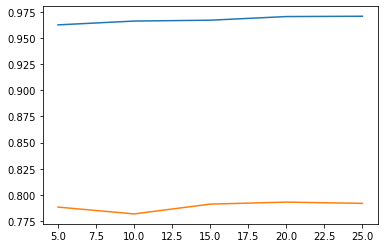

In [56]:
plt.plot(epochs,trainacc,label='training accuracy')
plt.plot(epochs,testacc,label='training accuracy')
plt.show()